In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'IWF'
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_iwf.pkl' # Russell 1000
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed
Generating derived columns...
(6148, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
2000-05-26,78.187500,78.187500,78.140625,78.140625,60.055332,4.095266,0.999400,1.018996,1.017197
2000-05-30,79.484375,79.625000,79.484375,79.625000,61.196167,4.114085,1.001769,1.031004,1.016876
2000-05-31,80.968750,82.093750,80.968750,82.093750,63.093521,4.144618,1.013894,1.009517,0.999429
2000-06-01,82.046875,83.187500,82.046875,82.875000,63.693966,4.154090,1.010093,1.036388,1.031863
2000-06-02,85.515625,85.890625,85.234375,85.890625,66.011650,4.189831,1.004385,0.994179,0.991086
2000-06-05,85.125000,86.000000,85.125000,85.390625,65.627373,4.183993,1.003120,1.002561,0.999817
2000-06-06,85.375000,85.671875,85.375000,85.609375,65.795464,4.186551,1.002745,0.996168,0.985946
2000-06-07,84.406250,85.281250,84.406250,85.281250,65.543312,4.182711,1.010367,0.993770,1.004031
2000-06-08,85.625000,85.640625,84.750000,84.750000,65.134987,4.176462,0.989781,1.003503,1.010693


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
2000-05-26     78.187500
2000-05-30     79.625000
2000-05-31     82.093750
2000-06-01     83.187500
2000-06-02     85.890625
                 ...    
2024-10-28    386.450012
2024-10-29    387.619995
2024-10-30    388.029999
2024-10-31    380.970001
2024-11-01    379.660004
Name: high, Length: 6145, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-01-02')  # first day of legit open/close values
SIM_START

Timestamp('2009-01-02 00:00:00')

In [7]:
len(df.index >= SIM_START)

6148

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear_ma', 'linear']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

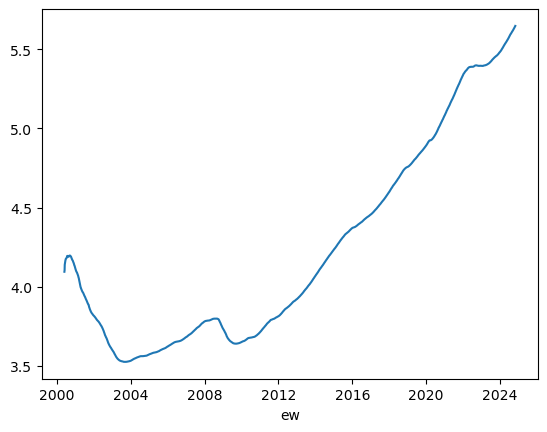

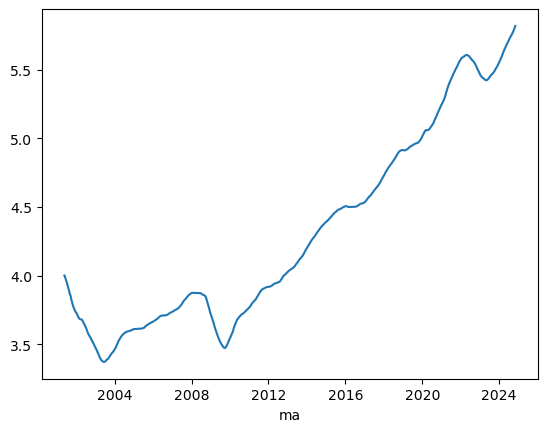

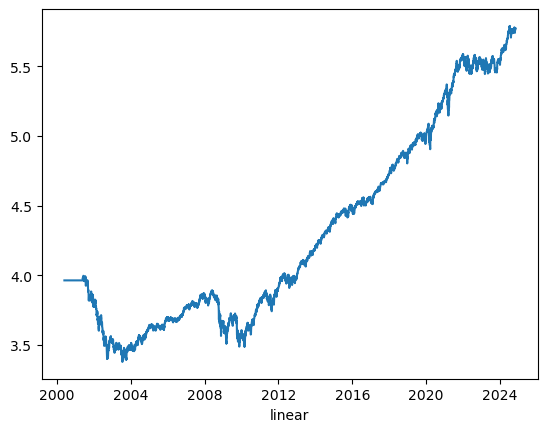

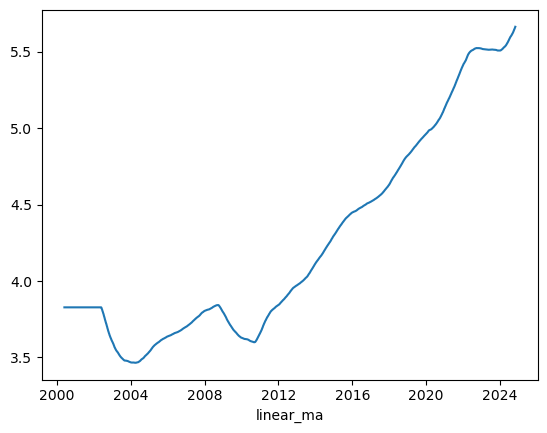

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params

(None, None)

Do nothing res: 11.883344853345562
Round 1: 1.244427071129763
New best: 1.244427071129763
{'time_param': 132, 'method': 'ew', 't': 0.1678665754997044, 'k': 0.5185674820524612, 'as_q': False, 'transform_f': 'bounded_curve'}


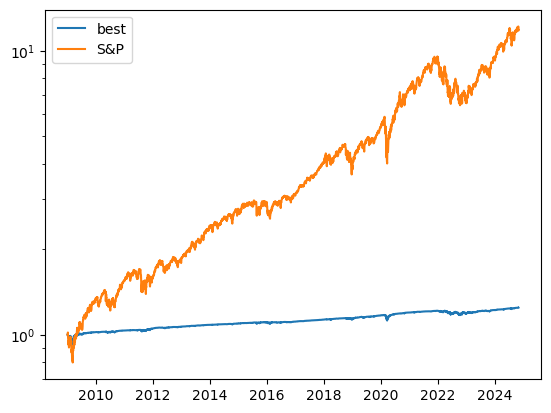

Round 2: 26.29019445832197
New best: 26.29019445832197
{'time_param': 64, 'method': 'linear_ma', 't': 0.9500817730263812, 'k': 0.3855700637751956, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


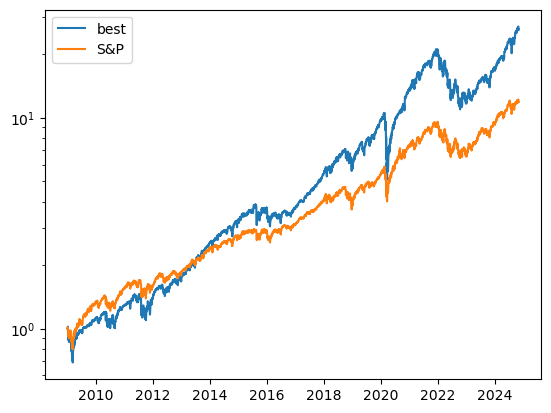

Round 3: 2.19187017291444
Round 4: 4.873229602351053
Round 5: 14.116204226081667
Round 6: 7.969401207845719
Round 7: 41.78262293520727
New best: 41.78262293520727
{'time_param': 33, 'method': 'ma', 't': 0.793551793022593, 'k': 5.166161901123136, 'as_q': False, 'transform_f': 'bounded_curve'}


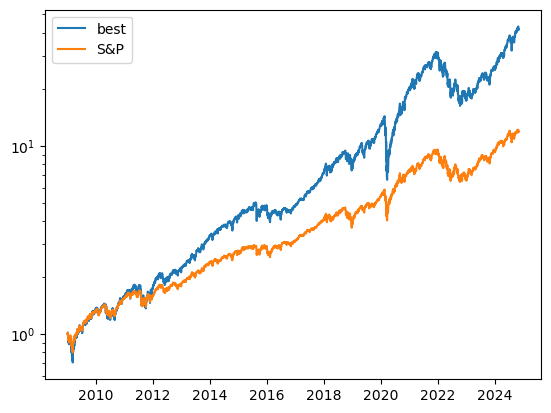

Round 8: 8.114714440639215
Round 9: 1.341255035287675
Round 10: 4.098851224901651
Round 11: 1.2947559507603672
Round 12: 39.94864473371287
Round 13: 39.0606870393982
Round 14: 7.915421399246515
Round 15: 1.2199009807416643
Round 16: 1.6754806330264447
Round 17: 12.924772243834068
Round 18: 0.9752452494187166
Round 19: 2.1860706660629177
Round 20: 6.371839043766633
Round 21: 10.765535958687096
Round 22: 7.419104998542513
Round 23: 2.8077133388745583
Round 24: 1.1779885683474587
Round 25: 28.467476990704803
Round 26: 4.439571762650923
Round 27: 9.215739881779616
Round 28: 38.37288929192886
Round 29: 5.809193303404813
Round 30: 1.3735307662132583
Round 31: 6.548912334089694
Round 32: 2.7862589610766326
Round 33: 6.826975433054922
Round 34: 19.64301315025935
Round 35: 6.188751645208542
Round 36: 4.750633968148836
Round 37: 1.327386421031347
Round 38: 36.236252771020226
Round 39: 3.711948202480846
Round 40: 12.566240217544031
Round 41: 13.679367660482932
Round 42: 36.6860772350206
Round 43:

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

Factor: 1.0625
Do nothing res: 11.883344853345562
Round 1: 41.784756008420615
New best: 41.784756008420615
{'time_param': 31, 'method': 'ma', 't': 0.7810019934195143, 'k': 5.307503338879461, 'as_q': False, 'transform_f': 'bounded_curve'}


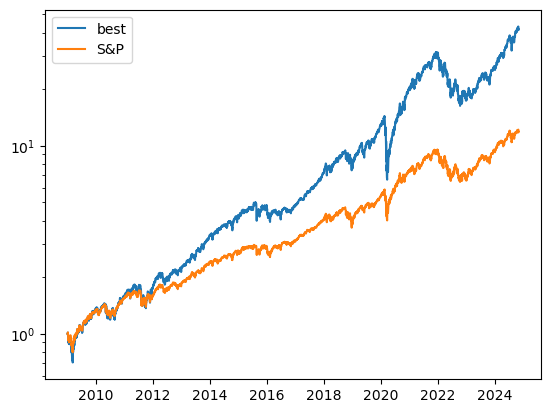

Round 2: 5.336325474796197
Round 3: 34.611938568860964
Round 4: 23.939083639491542
Round 5: 25.958314376613206
Round 6: 38.41354231801953
Round 7: 40.15224441172413
Round 8: 40.00993835172281
Round 9: 2.991655104577568
Round 10: 30.794554778329648
Round 11: 27.971380785869187
Round 12: 38.41280607971734
Round 13: 21.537046366942818
Round 14: 41.4594717460741
Round 15: 37.952699522440795
Round 16: 40.42487626436441
Round 17: 38.413900836280085
Round 18: 38.41280607971734
Round 19: 38.41280607971701
Round 20: 38.41280607971734
Round 21: 41.477242492588545
Round 22: 19.325736829561553
Round 23: 38.23638690348003
Round 24: 38.87742978089065
Round 25: 38.41280607971701

Factor: 1.03125
Do nothing res: 11.883344853345562
Round 1: 38.41280607971734
Round 2: 38.33884400240258
Round 3: 23.341037463496477
Round 4: 41.472671516907994
Round 5: 38.41280607971734
Round 6: 40.04967843780075
Round 7: 30.84428333037623
Round 8: 40.56854924176646
Round 9: 2.2266447208039275
Round 10: 15.756794327568713


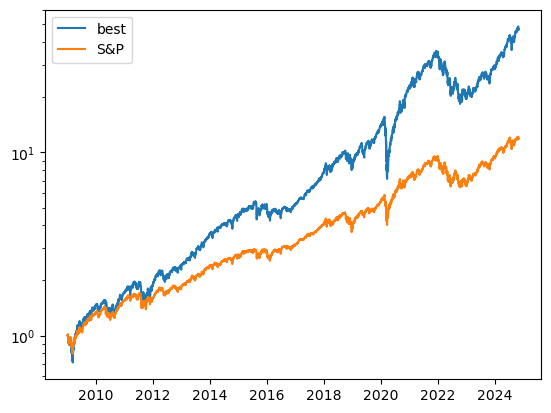

Round 16: 38.41280607971701
Round 17: 38.41280607971701
Round 18: 12.53722483103827
Round 19: 1.4626222345912792
Round 20: 38.41280607971701
Round 21: 38.41280607971701
Round 22: 46.742474745468236
Round 23: 46.431795828306726
Round 24: 3.177345799761171
Round 25: 1.3429911475350376

Factor: 1.015625
Do nothing res: 11.883344853345562
Round 1: 38.41280607971701
Round 2: 4.047233946590236
Round 3: 46.979736531108955
Round 4: 1.9905645676848407
Round 5: 38.41280607971701
Round 6: 4.508592422792793
Round 7: 38.41280607971701
Round 8: 40.174039338100386
Round 9: 46.09221725678278
Round 10: 38.41280607971701
Round 11: 44.26081307559131
Round 12: 38.41280607971701
Round 13: 1.0655038266069754
Round 14: 38.41280607971701
Round 15: 44.25873635812937
Round 16: 38.41280607971701
Round 17: 38.41280607971701
Round 18: 38.41280607971701
Round 19: 46.446858755576436
Round 20: 43.884971059347166
Round 21: 4.520591828606703
Round 22: 38.41280607971701
Round 23: 2.3239155766678867
Round 24: 45.54077323

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=25, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

In [20]:
# Force set:
#best_out = 8.746647001172413
#params_out = {'time_param': 39, 'method': 'ma', 't': 0.9119734669470952, 'k': 6.934678320149607, 'as_q': True, 'transform_f': 'bounded_curve'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999955257401781

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6842064046643145

In [24]:
params_out

{'time_param': 30,
 'method': 'ma',
 't': 0.898111135841463,
 'k': 5.22496453032843,
 'as_q': False,
 'transform_f': 'bounded_sigmoid'}

/Users/dsp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


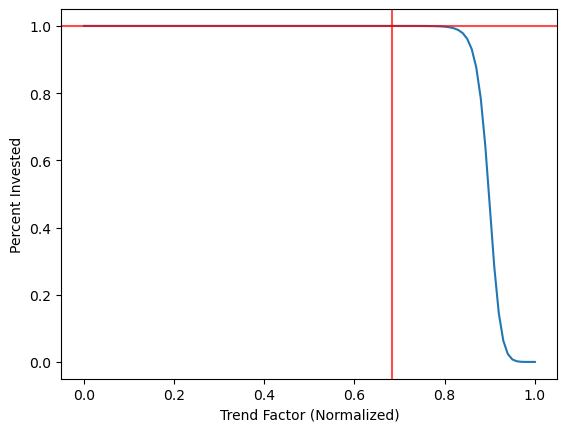

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

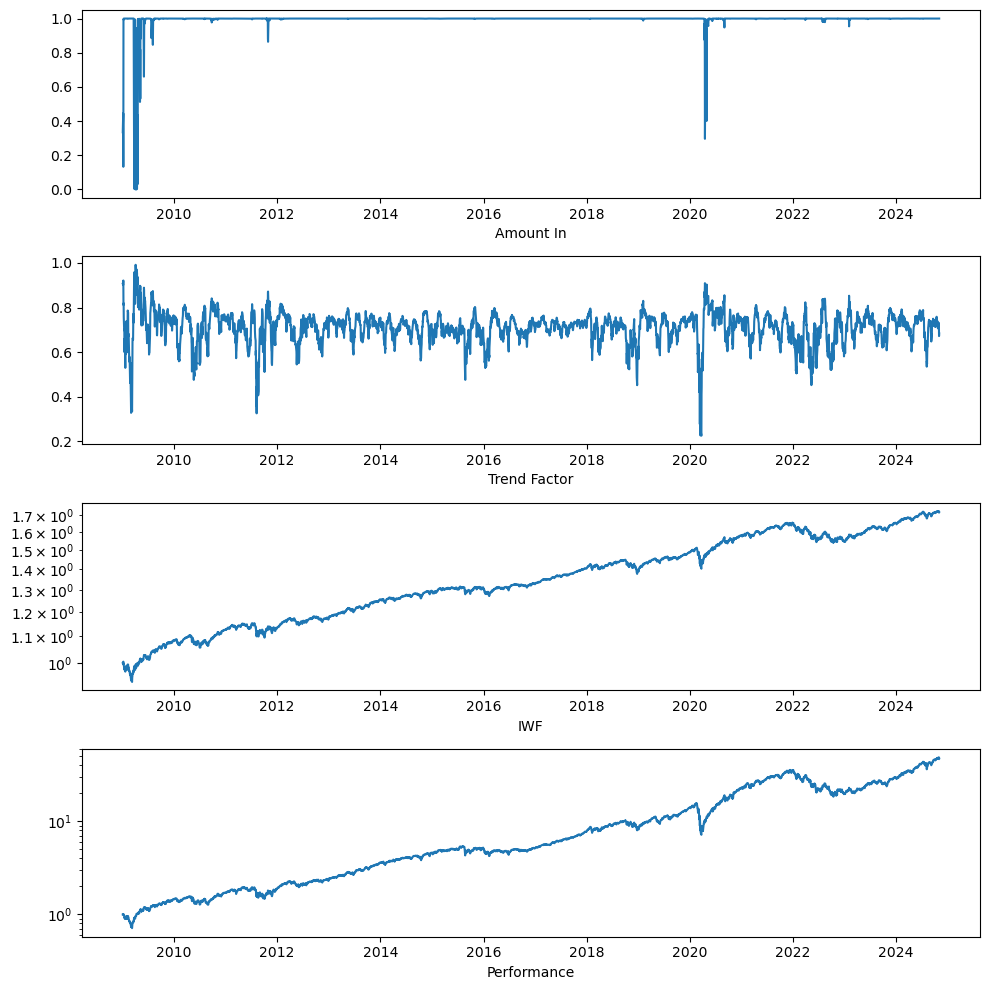

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('Wilshire')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

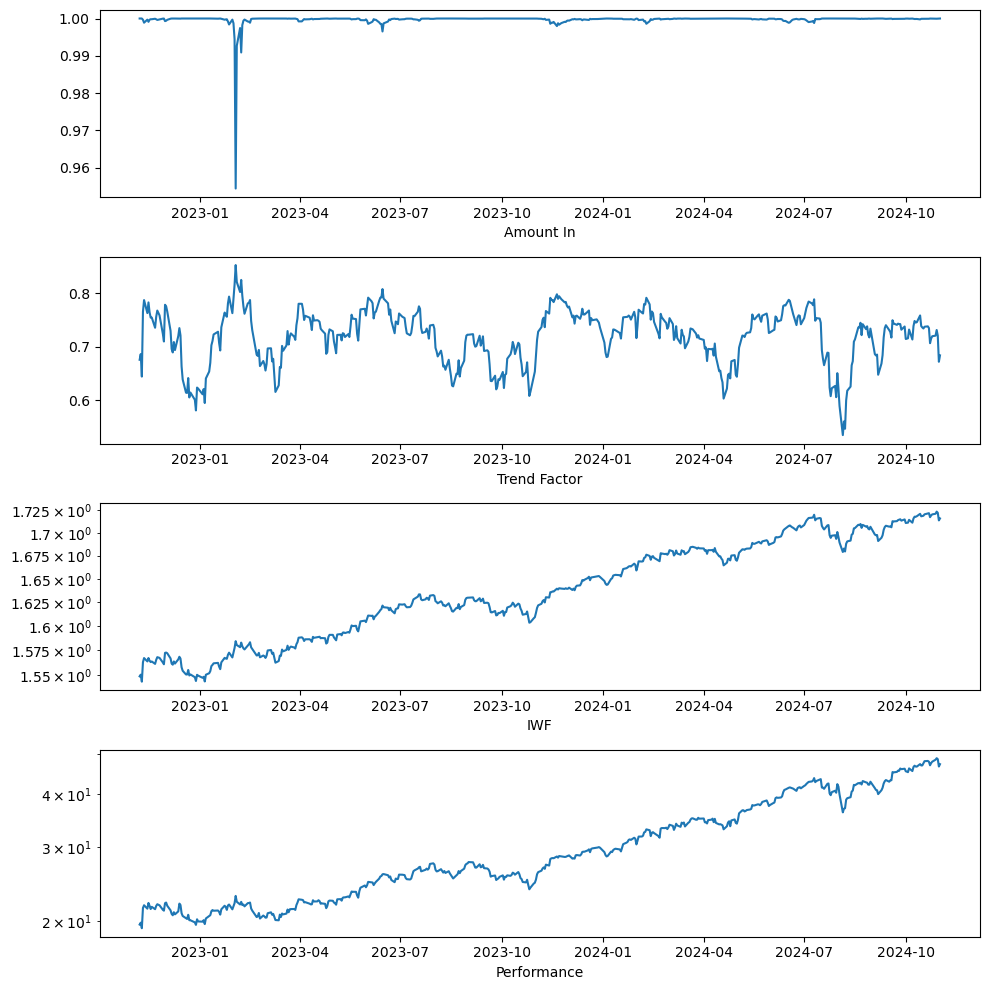

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('IWF')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(31.70908546447754, 15.944, 376.80999755859375)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.27341711267462543

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['rus'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1195809596024326, 1.0], 'nas': [1.2400991798626717, 1.0], 'rus': [1.2734171126746254, 1.0], 'jpxn': [1.0738414738575615, 0.9804], 'ktec': [1.6302079070835445, 0.0], 'emb': [1.0676797655679815, 0.9996], 'gdx': [1.3583771630868045, 0.1098], 'dia': [1.2135937638282468, 1.0], 'nfty': [1.2330869591330673, 1.0]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(47.168552661227665,
 {'time_param': 30,
  'method': 'ma',
  't': 0.898111135841463,
  'k': 5.22496453032843,
  'as_q': False,
  'transform_f': 'bounded_sigmoid'})